In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
from tqdm.notebook import tqdm
import numpy as np

# Clone GH for access to data
!git clone https://github.com/pvankatwyk/fake-reviews-classification

fatal: destination path 'fake-reviews-classification' already exists and is not an empty directory.


In [2]:
df = pd.read_csv("/content/fake-reviews-classification/data/fake_reviews_dataset.csv")

encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [3]:
maxlen=250
def process_data(df):
    token = tf.keras.preprocessing.text.Tokenizer()
    token.fit_on_texts(list(df['text_']))
    seq = token.texts_to_sequences(df['text_'])
    padded_seq = np.array(tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=maxlen))
    return padded_seq, token

In [4]:
X, tokenizer = process_data(df)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
vocab = tokenizer.word_index

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [
             tf.keras.layers.Dense(ff_dim, activation="relu"), 
             tf.keras.layers.Dense(embed_dim),
             ]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [7]:
class FakeReviewDetector(tf.keras.Model):
    def __init__(self, vocab, embed_dim, num_heads, ff_dim):
        super(FakeReviewDetector, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        self.batch_size = 32
        self.inputs = tf.keras.layers.Input(shape=(maxlen,))
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, len(vocab), embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.dense_hidden = tf.keras.layers.Dense(20, activation="relu")
        self.dense_out = tf.keras.layers.Dense(2, activation="softmax")

    def call(self, x):
        x = self.embedding_layer(x)
        x = self.transformer_block(x)
        x = self.pooling(x)
        x = self.dropout(x)
        x = self.dense_hidden(x)
        x = self.dropout(x)
        x = self.dense_out(x)
        return x

In [8]:
model = FakeReviewDetector(vocab=vocab, embed_dim=32, num_heads=2, ff_dim=32)

In [9]:
class SaveBatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, loss_list):
        super(SaveBatchLogs, self).__init__()
        self.loss_list = loss_list
    def on_train_batch_end(self, batch, logs=None): 
        self.loss_list.append(logs)

In [10]:
batch_logs = []
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=128, epochs=5, callbacks=SaveBatchLogs(batch_logs), validation_split=0.2
)

Epoch 1/5
170/170 [==============================] - 20s 65ms/step - loss: 0.4819 - accuracy: 0.7384 - val_loss: 0.2380 - val_accuracy: 0.8972
Epoch 2/5
170/170 [==============================] - 9s 51ms/step - loss: 0.2029 - accuracy: 0.9173 - val_loss: 0.1932 - val_accuracy: 0.9227
Epoch 3/5
170/170 [==============================] - 7s 44ms/step - loss: 0.1370 - accuracy: 0.9462 - val_loss: 0.1950 - val_accuracy: 0.9203
Epoch 4/5
170/170 [==============================] - 7s 44ms/step - loss: 0.1018 - accuracy: 0.9620 - val_loss: 0.2130 - val_accuracy: 0.9219
Epoch 5/5
170/170 [==============================] - 7s 44ms/step - loss: 0.0808 - accuracy: 0.9709 - val_loss: 0.2369 - val_accuracy: 0.9186


In [11]:
acc = []
loss = []
for log in batch_logs:
    loss.append(log['loss'])
    acc.append(log['accuracy'])

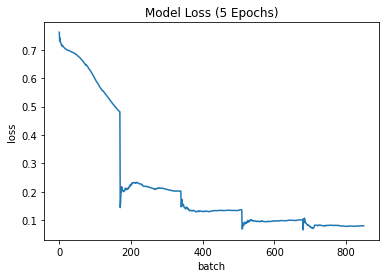

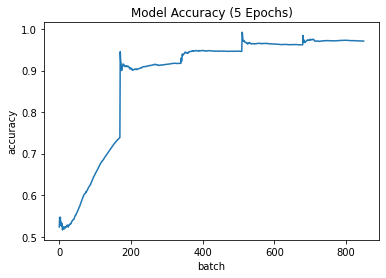

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss, label='loss')
plt.title('Model Loss (5 Epochs)')
plt.ylabel('loss')
plt.xlabel('batch')
plt.savefig(r'loss.png')
# files.download('loss.png')
plt.show()

plt.plot(acc, label='accuracy')
plt.title('Model Accuracy (5 Epochs)')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.savefig('accuracy.png')
# files.download('accuracy.png')
plt.show()

In [13]:
def predict(query, model, tokenizer):
    seq = tokenizer.texts_to_sequences([query])
    padded_seq = np.array(tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=maxlen))
    fake, real = model(padded_seq)[0].numpy()
    return fake, real

In [14]:
query = """I work in the wedding industry and have to work long days, on my feet, outside in the heat, and have to look professional. I've spent a ridiculous amount of money on high end dress shoes like Merrels and just have not been able to find a pair that are comfortable to wear all day. Both for my feet and my back. Enter the Sanuk yoga sling!!! These shoes are amazingly comfortable. Though, I will admit it took a few wears to get used to the feel of the yoga matte bottom. At first, it felt a little "sticky" to me, and the fabric part that goes through the toe area was a little thick and took some getting used to. I wore them for a few days before taking them out on a job and I can't get over how comfortable they are. Ii have been wearing these shoes now for 3 months, every work day and I am THRILLED. No more back pain, no more sore feet. I also wear these sometimes during my off time,mans every time I wear them, I get compliments on how cute and comfortable they look. The great thing about these shoes is the yoga matte bottom. It helps your feet grip to the shoe a bit, so your foot can just walk normally, without having to grip the shoe. You may not realize it, but with a lot of Sandals, your foot is having to work to keep the shoe on, changing the way you walk and stand and ultimately causing foot and back pain. Not with these! Also, the soft linen sits comfortably on your skin and breathes nicely in the heat. The only downside is the funky tan lines, which is why I am sure to alternate shoes on my days off, especially if I plan to be outside for most of the day. If it were not for that, I think these might be the only shoes I'd wear all summer. If you are looking for a reasonable priced, comfortable shoe that you can wear and walk in all day."""
fake, real = predict(query, model, tokenizer)
print(f"Real Probability: {real}\nFake Probability: {fake}")

Real Probability: 0.9998799562454224
Fake Probability: 0.0001200563128804788


In [15]:
query = """My old bet was wearing this to the Macy's in January.  This is the first one I've ever had.  I am a 32D, and the first pair I bought were just a little tight.  I'm a bit disappointed.  This is my second pair.  I'm looking forward to wearing them to the Macy's in the fall.  I like the way they look.Love these!These are my favorite.  I have a hard time finding jeans that fit me comfortably, but I have a hard time finding jeans that don't fit.  These jeans are super comfortable and have a great price point.  I have some great jeans to wear for work, but these are the only jeans that I wear for work or for my family.  I will be buying more!  I have a lot of compliments on them.I love these shoes. I love the color and the fit. They fit my body well and are comfortable. I have a wide foot and these fit me well.

I'm 5'4", 130lbs and these fit well. I would recommend them.I wear a size 11.5 in jeans and this fits perfect. I have a narrow foot and this fits perfect. It is very comfortable and fits great. I bought a small and it fit perfectly. I will order another size up.I bought these for my husband, he loves them and he loves them!This is the best pair of sunglasses for the price!  They are so comfortable and easy to use.  I wear them all the time and they don't hurt my feet.  I wear them everyday and my feet are so happy with them!"""
fake, real = predict(query, model, tokenizer)
print(f"Real Probability: {real}\nFake Probability: {fake}")

Real Probability: 9.872383816400543e-05
Fake Probability: 0.999901294708252


In [16]:
query = """I work in the wedding industry and have to work long days, on my feet, outside in the heat, and have to look professional. I've spent a ridiculous amount of money on high end dress shoes like Merrels and just have not been able to find a pair that are comfortable to wear all day. Both for my feet and my back. Enter the Sanuk yoga sling!!! These shoes are amazingly comfortable. Though, I will admit it took a few wears to get used to the feel of the yoga matte bottom. At first, it felt a little "sticky" to me, and the fabric part that goes through the toe area was a little thick and took some getting used to. I wore them for a few days before taking them out on a job and I can't get over how comfortable they are. Ii have been wearing these shoes now for 3 months, every work day and I am THRILLED. No more back pain, no more sore feet. I also wear these sometimes during my off time,mans every time I wear them, I get compliments on how cute and comfortable they look. The great thing about these shoes is the yoga matte bottom. It helps your feet grip to the shoe a bit, so your foot can just walk normally, without having to grip the shoe. You may not realize it, but with a lot of Sandals, your foot is having to work to keep the shoe on, changing the way you walk and stand and ultimately causing foot and back pain. Not with these! Also, the soft linen sits comfortably on your skin and breathes nicely in the heat. The only downside is the funky tan lines, which is why I am sure to alternate shoes on my days off, especially if I plan to be outside for most of the day. If it were not for that, I think these might be the only shoes I'd wear all summer. If you are looking for a reasonable priced, comfortable shoe that you can wear and walk in all day."""
fake, real = predict(query, model, tokenizer)
print(f"Real Probability: {real}\nFake Probability: {fake}")

Real Probability: 0.9998799562454224
Fake Probability: 0.0001200563128804788


In [17]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

417/417 [==============================] - 4s 9ms/step - loss: 0.2339 - accuracy: 0.9188


In [18]:
print(f'''Test Loss: {round(test_loss, 4)}
Test Accuracy: {round(test_acc, 4)}''')

Test Loss: 0.2339
Test Accuracy: 0.9188
